# Sentiment Analysis using sequential models

This notebook demonstrates the neural networks' performance in sentiment analysis.

Sentiment analysis is a task in NLP consisting of figuring out the feelings or opinions in a piece of writing. It looks at words and context to see if the tone is positive or negative. The main goal is to understand people's emotions or views expressed in the text. This technique is really useful in areas like marketing and social media to get a sense of what people think or feel about a product or topic.[1][2]

In our case we will train our models in order to analyse sentiments in restaurant reviews !

[1] https://www.freecodecamp.org/news/what-is-sentiment-analysis-a-complete-guide-to-for-beginners/

[2] https://en.wikipedia.org/wiki/Sentiment_analysis


N.B.: All our code is found on https://github.com/eliejaz/webNtextSentimentalAnalysis.


## Data Preparation

In order to train the model we used the **Yelp academic dataset** for restaurant reviews. 
2 versions of this dataset were used:  
*   The first one is only 100 000 reviews from https://github.com/knowitall/yelp-dataset-challenge/blob/master/data/yelp_phoenix_academic_dataset/yelp_academic_dataset_review.json 
*   the second one is the full dataset with a 5 Gb size from https://www.yelp.com/dataset/download.


We must prepare our data. This involves cleaning the text data, removing stop words, and converting the text into numerical form.

We have converted the ratings into sentiments by considering the 4 and 5 stars ratings to be a positive sentiment and the rest to be a negative sentiment.

### Imports

In [ ]:
import pandas as pd
import numpy as np
import json

import nltk
nltk.download('punkt')
nltk.download('stopwords')

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [1]:
# Load Yelp reviews data
reviews = []
with open('yelp_academic_dataset_review.json', encoding='utf-8') as f:
    for line in f:
        review = json.loads(line)
        sentiment = 1 if review['stars'] >= 4 else 0
        reviews.append((review['text'], sentiment))

df = pd.DataFrame(reviews, columns=['text', 'sentiment'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jadak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jadak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df.head()

,text,sentiment
0,My wife took me here on my birthday for breakf...,1
1,I have no idea why some people give bad review...,1
2,love the gyro plate. Rice is so good and I als...,1
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1
4,General Manager Scott Petello is a good egg!!!...,1


#### Data processing

After a quick inspection of our corpus we have noticed the need for data cleaning, which envolves the following:

*   Removal of html tags.
*   Removal of URLS.
*   Removal of emoticons, symbols and flags.
*   Removal of punctuation.
*   Stemming of words to their root stem.

In [4]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (IOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub("", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenise
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    filtered_tokens = [w for w in tokens if not w in stop_words and w.isalpha()]

    # Do stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return " ".join(stemmed_tokens)

In [5]:
df['processed_text'] = df['text'].apply(preprocess_text)
df.head(2)

,text,sentiment,processed_text
0,My wife took me here on my birthday for breakf...,1,wife took birthday breakfast excel weather per...
1,I have no idea why some people give bad review...,1,idea peopl give bad review place goe show plea...


### Save the processed data

In [6]:

df.to_csv('processed_data.csv', index=False)


## Model Training

Now that our data is prepared, we can train our models.



### Imports

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import gensim.downloader as api

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

In [7]:
#import dataframes from csv
# df = pd.read_csv('processed_data.csv')
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.2, random_state=42)

A quick look at our corpus.

In [8]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

counter = counter_word(df.processed_text)

counter

5000


Counter({'wife': 8814,
         'took': 18854,
         'birthday': 5052,
         'breakfast': 17945,
         'excel': 15995,
         'weather': 2485,
         'perfect': 17413,
         'made': 28697,
         'sit': 16361,
         'outsid': 13946,
         'overlook': 904,
         'ground': 2591,
         'absolut': 8782,
         'pleasur': 1337,
         'waitress': 11253,
         'food': 142972,
         'arriv': 10080,
         'quickli': 6150,
         'semibusi': 4,
         'saturday': 7638,
         'morn': 7232,
         'look': 51420,
         'like': 128345,
         'place': 170500,
         'fill': 10687,
         'pretti': 40076,
         'earlier': 1626,
         'get': 107898,
         'better': 33294,
         'favor': 1422,
         'bloodi': 1144,
         'mari': 1428,
         'phenomen': 1437,
         'simpli': 4155,
         'best': 44819,
         'ive': 47278,
         'ever': 25008,
         'im': 53424,
         'sure': 26973,
         'use': 27637,


## Tokenizers

We have used the keras tokenizer and tried 2 values for the num_words argument:
* The first one equal to the number of unique words in our processed corpus, where the mapping of words will follow the order of occurence
* The second one equal to 5000, where only the mapping of the 5000 most frequent words will take place.

A maximum review text length of 200 was adopted since its about the same as the average number of words per review text.

For consistency we truncated and padded the review text to this fixed size.

In [9]:
# num_words = len(counter)
# print(num_words)
num_words = 5000

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df.processed_text)
# save tokenizer
import pickle
with open('tokenizer_fastText.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

vocab_length = len(tokenizer.word_index)+1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

## Embedding layer

Both pretrained and trainable embedding layers where tested:

* A trainable layer with input_dim = 5000 and output_dim = 16 (a dense 1D vector of size 16)
* 3 pretrained embedding models: 
    *  Word2Vec "word2vec-google-news-300", output_dim = 300
    *  GloVe "glove-wiki-gigaword-100", output_dim = 100
    *  FastText "fasttext-wiki-news-subwords-300", output_dim = 300

In [10]:
pretrained_embedding_model = api.load("fasttext-wiki-news-subwords-300")
# pretrained_embedding_model = api.load("glove-wiki-gigaword-100")
# pretrained_embedding_model = api.load("word2vec-google-news-300")

* Without spellchecking and corrections we notice that choosing 5000 as maximum words is a wise choice since same words with different spellings will have different embeddings and thus not capture the true meaning of the words.

Here we adapt the embedding matrix to our vocabulary size and the words in our corpus.

In [11]:
embedding_dim = pretrained_embedding_model.vector_size

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in pretrained_embedding_model:
        embedding_matrix[i] = pretrained_embedding_model[word]

# GRU model using Keras library.

In [12]:

model = Sequential()

# model.add(Embedding(5000, 16, input_length=200))
model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=200,
                    trainable=False))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


2 batch_sizes of 32 and 64 were tested, with the 32 model showing slightly better results.

The model was trained over 5 epochs.

In [14]:
history = model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=32)

Epoch 1/5
5748/5748 [==============================] - 446s 78ms/step - loss: 0.3436 - accuracy: 0.8496 - val_loss: 0.3493 - val_accuracy: 0.8466
Epoch 2/5
5748/5748 [==============================] - 458s 80ms/step - loss: 0.3364 - accuracy: 0.8532 - val_loss: 0.3496 - val_accuracy: 0.8458
Epoch 3/5
5748/5748 [==============================] - 465s 81ms/step - loss: 0.3301 - accuracy: 0.8559 - val_loss: 0.3421 - val_accuracy: 0.8504
Epoch 4/5
5748/5748 [==============================] - 453s 79ms/step - loss: 0.3245 - accuracy: 0.8581 - val_loss: 0.3417 - val_accuracy: 0.8492
Epoch 5/5
5748/5748 [==============================] - 453s 79ms/step - loss: 0.3198 - accuracy: 0.8607 - val_loss: 0.3519 - val_accuracy: 0.8470


In [15]:
# save the model
model.save('model.h5')

In [ ]:
# #load the model 
# from tensorflow.keras.models import load_model
# model = load_model('model.h5')


## Model Evaluation

After training, we evaluate our model on the test data to see how well it performs.

We used the SKlearn library for its diverse binary classification performance metrics.

### Imports

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print('Test accuracy:', accuracy)

1437/1437 [==============================] - 51s 35ms/step - loss: 0.3519 - accuracy: 0.8470
Test accuracy: 0.8470271229743958


In [28]:
y_pred = model.predict(X_test_pad)

1437/1437 [==============================] - 52s 36ms/step


### ROC Curve and optimal Threshold:

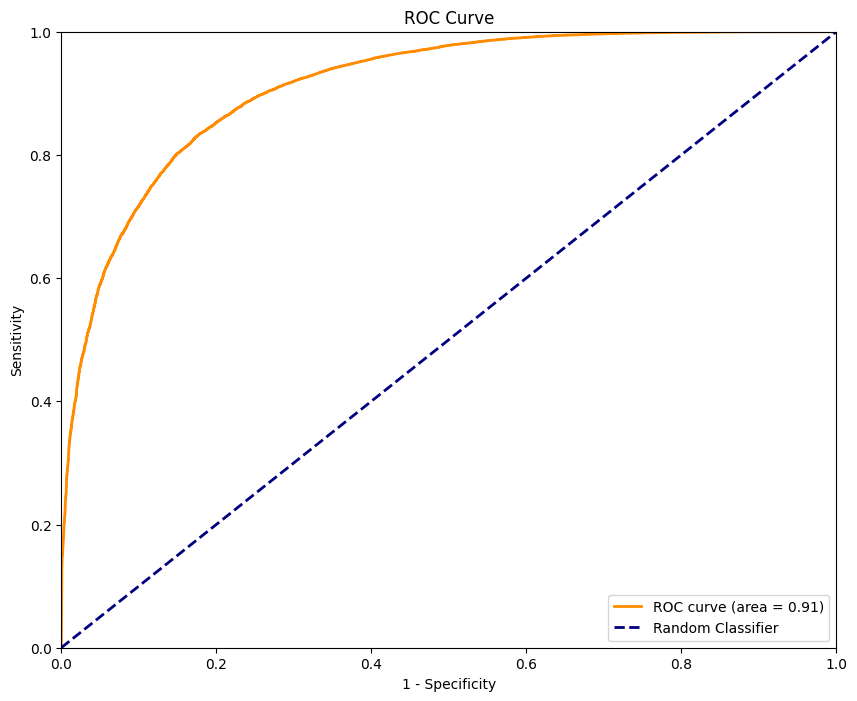

Threshold value is: 0.64995724


[1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,


In [32]:
def pl(y_test, y_pred_5g):
    # roc curve to y_test and y_pred
    fpr_5, tpr_5, thresholds_5 = roc_curve(y_test, y_pred_5g)
    # Calculate the area under the ROC curve (AUC-ROC)
    roc_auc_5 = auc(fpr_5, tpr_5)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_5, tpr_5, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_5)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.00])
    plt.title('ROC Curve')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

    # get best threshold
    optimal_idx_5 = np.argmax(tpr_5 - fpr_5)
    optimal_threshold_5 = thresholds_5[optimal_idx_5]
    print("Threshold value is:", optimal_threshold_5)

    # get predictions based on optimal threshold
    y_pred_optimal = [1 if i >= optimal_threshold_5 else 0 for i in y_pred_5g]

    return y_pred_optimal

pl(y_test, y_pred)

* Contingency table and Performance Metrics using "optimal threshold" !

[[12086  2741]
 [ 5230 25925]]


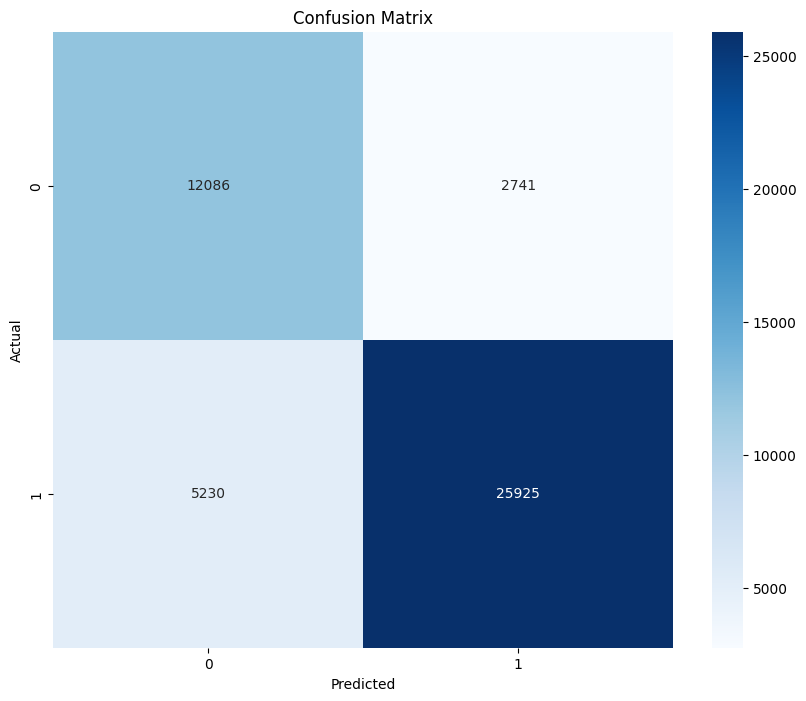

              precision    recall  f1-score   support

           0       0.70      0.82      0.75     14827
           1       0.90      0.83      0.87     31155

    accuracy                           0.83     45982
   macro avg       0.80      0.82      0.81     45982
weighted avg       0.84      0.83      0.83     45982



In [40]:
# get predictions based on optimal threshold
y_pred_optimal = [1 if i >= optimal_threshold else 0 for i in y_pred]

# confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)
print(cm)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# classification report
print(classification_report(y_test, y_pred_optimal))


In [18]:
# load yelp_sentiment_model.tf model
import tensorflow as tf
model_5g = tf.keras.models.load_model('yelp_sentiment_model.tf')


In [19]:
model_5g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           80000     
                                                                 
 gru (GRU)                   (None, 32)                4800      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 84,833
Trainable params: 84,833
Non-trainable params: 0
_________________________________________________________________


In [21]:
# predict the values using this model
y_pred_5g = model_5g.predict(X_test_pad)


1437/1437 [==============================] - 30s 21ms/step


[[ 4464 10363]
 [10055 21100]]


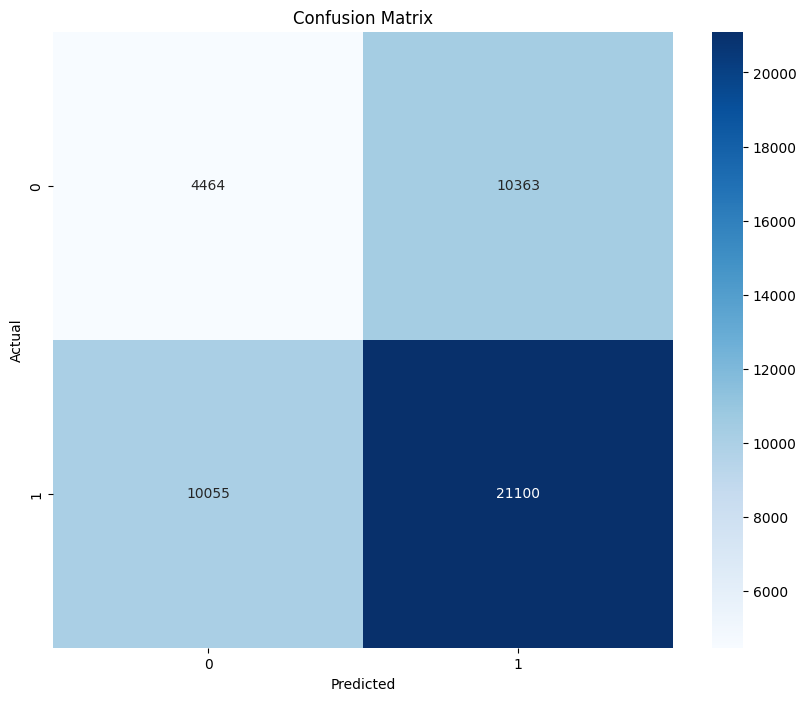

In [23]:
# use 0.5 threshold to get the final predictions
y_pred_5g = [1 if i >= 0.5 else 0 for i in y_pred_5g]
cm = confusion_matrix(y_test, y_pred_5g)
print(cm)
# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
print(classification_report(y_test, y_pred_5g))

              precision    recall  f1-score   support

           0       0.31      0.30      0.30     14827
           1       0.67      0.68      0.67     31155

    accuracy                           0.56     45982
   macro avg       0.49      0.49      0.49     45982
weighted avg       0.55      0.56      0.55     45982



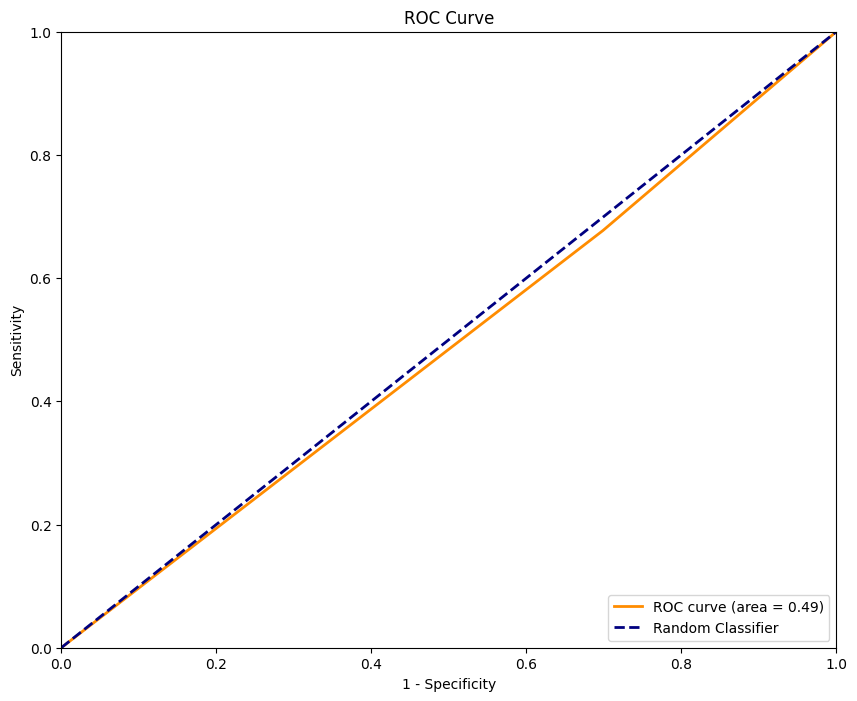

Threshold value is: 2


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [33]:
pl(y_test, y_pred_5g)

In [10]:
def preprocess_and_predict(text):
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Convert to a sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=200)

    # Predict
    prediction = model.predict(padded_sequence)

    return 'Positive' if prediction[0][0] > 0.5 else 'Negative'

In [ ]:
# Test with a positive review
input_text = "The food was absolutely wonderful, from preparation to presentation, very pleasing."
predicted_sentiment = preprocess_and_predict(input_text)
print(f'Review is: {predicted_sentiment}')

# Test with a negative review
negative_input_text = "Unfortunately, the experience was disappointing. The service was slow and the food was bland. Definitely not worth the price."
negative_predicted_sentiment = preprocess_and_predict(negative_input_text)
print(f'Review is: {negative_predicted_sentiment}')

### Web Scraping 

web scraping trip advisor for our local **huggy's** branch's reviews

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
import time

PATH = "C:\\Users\\jadak\\Documents\\webNtext\\Projects\\ELIE_JAD\\chromedriver-win64\\chromedriver.exe"
service = Service(PATH)
driver = webdriver.Chrome(service=service)

url = "https://www.tripadvisor.com/Restaurant_Review-g188655-d3669408-Reviews-The_Huggy_s_Bar_Liege_1-Liege_Liege_Province_The_Ardennes_Wallonia.html"
driver.get(url)
my_reviews = []
my_ratings = []
while True:
    time.sleep(2)

    container = driver.find_elements(By.XPATH, ".//div[@class='review-container']")
    for review_box in container:
        try:
            more_link = driver.find_element(By.XPATH, "//span[@class='taLnk ulBlueLinks']")
            driver.execute_script("arguments[0].click();", more_link)
        except Exception:
            print("No 'More' link found")

        try:
            title = review_box.find_element(By.XPATH, ".//span[@class='noQuotes']").text
            date = review_box.find_element(By.XPATH, ".//span[contains(@class, 'ratingDate')]").get_attribute("title")
            rating_class = review_box.find_element(By.XPATH, ".//span[contains(@class, 'ui_bubble_rating bubble_')]").get_attribute("class")
            rating = rating_class.split("_")[3]
            rating = int(rating)

            if rating >= 10:
                rating = int(rating / 10)

            review = review_box.find_element(By.XPATH, ".//p[@class='partial_entry']").text.replace("\n", " ")
            my_ratings.append(rating)
            my_reviews.append(review.encode('ascii', 'ignore').decode())
        except Exception:
            print("Missing fields in a review")

    try:
        next_button = driver.find_element(By.XPATH, './/a[@class="nav next ui_button primary"]')
        driver.execute_script("arguments[0].click();", next_button)
    except NoSuchElementException:
        print("No more pages to scrape.")
        break

driver.close()

" transform into dataframe "
import pandas as pd
df = pd.DataFrame(list(zip(my_reviews, my_ratings)), columns=['Review', 'Rating'])
# current working directory

df.to_csv(r'Reviews_huugysbar.csv',index=False, header=False)

## Model Deployment

In [ ]:
#load the model 
from tensorflow.keras.models import load_model

# load inference model
model = load_model('model.h5')

# Load the dataframe from reviews_huugysbar.csv
df_huugysbar = pd.read_csv('reviews_huugysbar.csv')

# Apply the text processing function to the 'review' column
df_huugysbar['processed_review'] = df_huugysbar['review'].apply(preprocess_text)

# Convert the 'processed_review' column to a list
processed_review_list = df_huugysbar['processed_review'].tolist()

# Convert rating to sentiment
df_huugysbar['sentiment'] = df_huugysbar['rating'].apply(lambda x: 1 if x >= 4 else 0)

# text to sequence the reviews
sequence = tokenizer.texts_to_sequences(processed_review_list)
padded_sequence = pad_sequences(sequence, maxlen=200)

# predict the sentiment
df_huugysbar['predicted_sentiment'] = model.predict(padded_sequence)

# convert the predicted sentiment to 1 or 0 using the optimal threshold
df_huugysbar['predicted_sentiment'] = df_huugysbar['predicted_sentiment'].apply(lambda x: 1 if x >= optimal_threshold else 0)

# save the dataframe
df_huugysbar.to_csv('reviews_huugysbar_predicted.csv', index=False)

# do contingency table
contingency_table = pd.crosstab(df_huugysbar['sentiment'], df_huugysbar['predicted_sentiment'], margins=True)

# calculate accuracy using sklearn
accuracy = accuracy_score(df_huugysbar['sentiment'], df_huugysbar['predicted_sentiment'])

